# Crear el dataset de viajes concretados, con tratamientos a las columnas pertinentes

## Liberías

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
import seaborn as sns
import miceforest as mf

## Cargar el dataset

In [11]:
CSV_PATH = 'output/uber_rides_enriched.csv'

In [12]:
df = pd.read_csv(
        CSV_PATH,
        parse_dates=['start_at','end_at','arrived_at','time_grid'],
    )

# Localizamos las fechas en la zona horaria de Lima
for col in ['start_at', 'end_at', 'arrived_at', 'time_grid']:
    df[col] = df[col].dt.tz_localize(
        'America/Lima',
        ambiguous='NaT',
        nonexistent='shift_forward'
    )

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23111 entries, 0 to 23110
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype                       
---  ------                  --------------  -----                       
 0   user_id                 23111 non-null  object                      
 1   driver_id               19726 non-null  object                      
 2   icon                    23111 non-null  object                      
 3   start_type              23111 non-null  object                      
 4   start_at                23111 non-null  datetime64[ns, America/Lima]
 5   start_lat               22212 non-null  float64                     
 6   start_lon               22212 non-null  float64                     
 7   end_at                  22835 non-null  datetime64[ns, America/Lima]
 8   end_lat                 22212 non-null  float64                     
 9   end_lon                 22212 non-null  float64                     
 10

In [14]:
df.drop(
    columns=[
        'duration',
        'distance',
        'price_distance',
        'price_duration',
        'cost',
        'cost_distance',
        'cost_duration',
    ],
    inplace=True
)

In [15]:
# Filas con coordenadas nulas y end_state == 'drop off'
mask = (
    df['start_lat'].isna() &
    (df['end_state'] == 'drop off')
)

# Cuántas filas son
print(f"Se eliminan {mask.sum()} ({mask.sum()/len(df):.2%}) filas de un total de {len(df)}")

# Eliminar esas filas
df = df.loc[~mask].copy()

Se eliminan 533 (2.31%) filas de un total de 23111


In [16]:
print(f'Filas duplicadas: {df.duplicated().sum()} ({(df.duplicated().sum()/df.shape[0]):.2%})')

df.drop_duplicates(inplace=True)

Filas duplicadas: 18 (0.08%)


In [17]:
duplicados_por_viaje = df.duplicated(subset=['user_id', 'driver_id', 'start_at', 'start_lat','start_lon','end_lat','end_lon' ,'end_state','icon','start_type','end_at']).sum()
print(f"Duplicados por combinación clave de viaje: {duplicados_por_viaje}")

Duplicados por combinación clave de viaje: 0


In [18]:
df_drop = df[
    df.end_state == 'drop off'
].copy()

df_n = df[
    ~(df.end_state == 'drop off')
].drop(
    columns=[
        'end_lat',
        'end_lon',
        'arrived_at',
        'driver_score',
        'rider_score',
        'dist_start_to_end_m',
        'time_start_to_end_s',
    ]
).copy()

## Valores atípicos y faltantes

In [19]:
# ------------------------------------------------------------
# (2) Calcular wait_calc (clip a 0) y trip_calc (sin clip)
# ------------------------------------------------------------
df_drop['wait_calc'] = (
    (df_drop['arrived_at'] - df_drop['start_at'])
    .dt.total_seconds()
    .clip(lower=0)
)

df_drop['trip_start'] = df_drop[['start_at', 'arrived_at']].max(axis=1)
df_drop['trip_calc'] = (
    (df_drop['end_at'] - df_drop['trip_start'])
    .dt.total_seconds()
)

# ------------------------------------------------------------
# (3) Calcular velocidades y banderas de inconsistencias graves
# ------------------------------------------------------------
VEL_MIN = 5       # km/h mínimo plausible
VEL_MAX = 150     # km/h máximo plausible
DIST_UMBRAL = 50  # metros: umbral para “distancia significativa”

# TRIP
df_drop['speed_real_trip_kmh'] = (
    df_drop['dist_start_to_end_m'] / df_drop['trip_calc']
).replace([np.inf, -np.inf], np.nan) * 3.6

df_drop['speed_api_trip_kmh'] = (
    df_drop['dist_start_to_end_m'] / df_drop['time_start_to_end_s']
).replace([np.inf, -np.inf], np.nan) * 3.6

df_drop['flag_inconsistencia_grave_trip'] = (
    (df_drop['speed_real_trip_kmh'] < VEL_MIN) |
    (df_drop['speed_real_trip_kmh'] > VEL_MAX) |
    (df_drop['trip_calc'] < 0) |
    ((df_drop['trip_calc'] == 0) & (df_drop['dist_start_to_end_m'] >= DIST_UMBRAL))
)

# WAIT (sin cambios en la lógica de inconsistencias graves)
df_drop['speed_real_wait_kmh'] = (
    df_drop['dist_driver_to_start_m'] / df_drop['wait_calc']
).replace([np.inf, -np.inf], np.nan) * 3.6

df_drop['speed_api_wait_kmh'] = (
    df_drop['dist_driver_to_start_m'] / df_drop['time_driver_to_start_s']
).replace([np.inf, -np.inf], np.nan) * 3.6

df_drop['flag_inconsistencia_grave_wait'] = (
    (df_drop['speed_real_wait_kmh'] < VEL_MIN) |
    (df_drop['speed_real_wait_kmh'] > VEL_MAX) |
    ((df_drop['wait_calc'] == 0) & (df_drop['dist_driver_to_start_m'] >= DIST_UMBRAL))
)

# ------------------------------------------------------------
# (4) Definir factores de corrección
# ------------------------------------------------------------
factor_trip = 2.0   # ×200 % para TRIP
factor_wait = 3.5   # ×350 % para WAIT

df_drop['api_time_corr_trip'] = df_drop['time_start_to_end_s'] * factor_trip
df_drop['api_time_corr_wait'] = df_drop['time_driver_to_start_s'] * factor_wait

# ------------------------------------------------------------
# (5) Calcular errores absolutos y relativos corregidos
# ------------------------------------------------------------
df_drop['error_abs_trip']      = (df_drop['trip_calc'] - df_drop['time_start_to_end_s']).abs()
df_drop['error_rel_corr_trip'] = (
    (df_drop['trip_calc'] - df_drop['api_time_corr_trip']).abs() /
    df_drop['api_time_corr_trip'].replace({0: np.nan})
)

df_drop['error_abs_wait']      = (df_drop['wait_calc'] - df_drop['time_driver_to_start_s']).abs()
df_drop['error_rel_corr_wait'] = (
    (df_drop['wait_calc'] - df_drop['api_time_corr_wait']).abs() /
    df_drop['api_time_corr_wait'].replace({0: np.nan})
)

# ------------------------------------------------------------
# (6) Construir subconjuntos "válidos" usando dropna temporal
# ------------------------------------------------------------
df_trip_valid = df_drop.dropna(subset=['trip_calc']).loc[
    (df_drop['time_start_to_end_s'] > 0) &
    (~df_drop['flag_inconsistencia_grave_trip']) &
    (df_drop['error_rel_corr_trip'] < 20)
].copy()

df_wait_valid = df_drop.dropna(subset=['wait_calc']).loc[
    (df_drop['time_driver_to_start_s'] > 0) &
    (~df_drop['flag_inconsistencia_grave_wait']) &
    (df_drop['error_rel_corr_wait'] < 50)
].copy()

# ------------------------------------------------------------
# (7) Calcular umbrales globales de percentil 95 (P95) para TRIP y WAIT
# ------------------------------------------------------------
ABS_THRESH_TRIP  = df_trip_valid['error_abs_trip'].quantile(0.95)
REL_THRESH_TRIP  = df_trip_valid['error_rel_corr_trip'].quantile(0.95)
SMALL_TIME_TRIP  = 60   # usar relativo si api_time ≥ 60 s

ABS_THRESH_WAIT  = df_wait_valid['error_abs_wait'].quantile(0.95)
REL_THRESH_WAIT  = df_wait_valid['error_rel_corr_wait'].quantile(0.95)
SMALL_TIME_WAIT  = 60   # usar relativo si api_time ≥ 60 s

# ------------------------------------------------------------
# (8) Definir umbrales dinámicos contínuos para TRIP
#    (ahora con base estadística empírica y función no lineal)
# ------------------------------------------------------------
def obtener_umbrales_trip(api_time_s):
    """
    Umbrales continuos para TRIP, basados en ajustes de regresión cuantílica
    y heteroscedasticidad estimada:

      1) abs_b = c * (api_time_s ** b), con c=0.247, b=0.9
      2) rel_b = L + (U - L) / [1 + exp(alpha * (api_time_s - beta))],
         con U=1.0, L=0.3, alpha=0.002, beta=600
      3) sm_b = 200  (no aplicar relativo si api_time_s < 200 s)
    """
    c = 0.247
    b = 0.9
    abs_b = c * (api_time_s ** b)

    U = 1.0
    L = 0.3
    alpha = 0.002
    beta = 600.0
    rel_b = L + (U - L) / (1 + np.exp(alpha * (api_time_s - beta)))

    sm_b = 200  # segundos

    return abs_b, rel_b, sm_b

# ------------------------------------------------------------
# (9) Preparar mediana de wait_calc por hora para filas sin coords
# ------------------------------------------------------------
df_drop['hour'] = df_drop['start_at'].dt.hour
mediana_por_hora = (
    df_drop.loc[df_drop['arrived_at'].notna()]
           .groupby('hour')['wait_calc']
           .median()
           .rename('mediana_wait_por_hora')
)

T_MAX  = 7200   # 2 horas en segundos: umbral absoluto si faltan coords
FACTOR = 3      # factor relativo sobre mediana por hora si faltan coords

# ------------------------------------------------------------
# (10) Definir funciones de detección de discrepancias
# ------------------------------------------------------------
def detectar_discrepancia_trip(row):
    """
    Detecta discrepancias en TRIP con una banda permisiva del 20 %:
      • No marca si trip_calc ∈ [0.8×api_time, api_time].
      • Si trip_calc < 0.8×api_time, aplica umbrales continuos (abs_b, rel_b, sm_b).
      • Mantiene chequeos globales de percentil 95 y de inconsistencias graves.
    """
    dist     = row['dist_start_to_end_m']
    api_time = row['time_start_to_end_s']
    trip     = row['trip_calc']
    hour     = row['hour']

    # --- Caso A: faltan coords de TRIP ---
    if pd.isna(dist) or pd.isna(api_time):
        if pd.notna(trip) and trip > T_MAX:
            return True
        if pd.notna(trip):
            umbral_hora = (mediana_por_hora.loc[hour]
                           if hour in mediana_por_hora.index
                           else mediana_por_hora.median()) * FACTOR
            if trip > umbral_hora:
                return True
        return False

    # --- Caso B: hay coords ---
    # (1) Inconsistencia grave (vel fuera de rango)
    if row['flag_inconsistencia_grave_trip']:
        return True

    # (2) api_time = 0 y distancia significativa
    if api_time == 0 and dist >= DIST_UMBRAL:
        return True

    # (3) Relativo global (P95) si trip_calc < api_time_corr_trip y api_time ≥ 60 s
    if api_time >= SMALL_TIME_TRIP and trip < row['api_time_corr_trip']:
        rel_corr = abs(trip - row['api_time_corr_trip']) / row['api_time_corr_trip']
        if rel_corr > REL_THRESH_TRIP:
            return True

    # (4) Si trip_calc < 0.8×api_time, aplicar umbrales continuos; 
    #     si trip_calc ∈ [0.8×api_time, api_time], NO marcar discrepancia
    if trip < api_time * 0.8:
        abs_b, rel_b, sm_b = obtener_umbrales_trip(api_time)
        # (4a) Umbral absoluto continuo
        if (api_time - trip) > abs_b:
            return True
        # (4b) Umbral relativo sigmoidal
        if api_time >= sm_b and trip < row['api_time_corr_trip']:
            rel_corr_b = abs(trip - row['api_time_corr_trip']) / row['api_time_corr_trip']
            if rel_corr_b > rel_b:
                return True

    return False


def detectar_discrepancia_wait(row):
    """
    Detecta discrepancias en WAIT de forma simétrica:
      • No marca si wait_calc ∈ [0.8×api_time, api_time].
      • Si wait_calc < 0.8×api_time, aplicar umbrales continuos (abs_b, rel_b, sm_b).
      • Mantiene chequeos globales de percentil 95 y de inconsistencias graves.
    """
    dist     = row['dist_driver_to_start_m']
    api_time = row['time_driver_to_start_s']
    wait     = row['wait_calc']
    hour     = row['hour']

    # --- Caso A: faltan coords de WAIT ---
    if pd.isna(dist) or pd.isna(api_time):
        if pd.notna(wait) and wait > T_MAX:
            return True
        if pd.notna(wait):
            umbral_hora = (mediana_por_hora.loc[hour]
                           if hour in mediana_por_hora.index
                           else mediana_por_hora.median()) * FACTOR
            if wait > umbral_hora:
                return True
        return False

    # --- Caso B: hay coords ---
    if row['flag_inconsistencia_grave_wait']:
        return True
    if api_time == 0 and dist >= DIST_UMBRAL:
        return True

    # (3) Relativo global (P95) si wait_calc < api_time_corr_wait y api_time ≥ 60 s
    if api_time >= SMALL_TIME_WAIT and wait < row['api_time_corr_wait']:
        rel_corr = abs(wait - row['api_time_corr_wait']) / row['api_time_corr_wait']
        if rel_corr > REL_THRESH_WAIT:
            return True

    # (4) Si wait_calc < 0.8×api_time, aplicar umbrales continuos
    if wait < api_time * 0.8:
        abs_b, rel_b, sm_b = obtener_umbrales_trip(api_time)
        # Umbral absoluto continuo
        if (api_time - wait) > abs_b:
            return True
        # Umbral relativo sigmoidal
        if api_time >= sm_b:
            rel_corr_b = abs(wait - row['api_time_corr_wait']) / row['api_time_corr_wait']
            if rel_corr_b > rel_b:
                return True

    return False

# ------------------------------------------------------------
# (11) Aplicar la detección de discrepancias a todo df_drop
# ------------------------------------------------------------
df_drop['flag_discrepancia_trip'] = df_drop.apply(detectar_discrepancia_trip, axis=1)
df_drop['flag_discrepancia_wait'] = df_drop.apply(detectar_discrepancia_wait, axis=1)

# ------------------------------------------------------------
# (12) Contar resultados finales
# ------------------------------------------------------------
n_total     = len(df_drop)
n_disc_trip = df_drop['flag_discrepancia_trip'].sum()
n_disc_wait = df_drop['flag_discrepancia_wait'].sum()

print(f"Total de filas en df_drop:                {n_total}")
print(f"Viajes TRIP marcados como discrepancia:   {n_disc_trip} ({n_disc_trip / n_total:.2%})")
print(f"Viajes WAIT marcados como discrepancia:   {n_disc_wait} ({n_disc_wait / n_total:.2%})\n")

print(" Estadísticas error_rel_corr_trip:\n", df_drop['error_rel_corr_trip'].describe(), "\n")
print(" Estadísticas error_rel_corr_wait:\n", df_drop['error_rel_corr_wait'].describe(), "\n")

# ------------------------------------------------------------
# (13) Eliminar columna auxiliar 'hour' si ya no se necesita
# ------------------------------------------------------------
df_drop.drop(columns=['hour'], inplace=True)


Total de filas en df_drop:                16884
Viajes TRIP marcados como discrepancia:   3591 (21.27%)
Viajes WAIT marcados como discrepancia:   9137 (54.12%)

 Estadísticas error_rel_corr_trip:
 count    16880.000000
mean         0.619371
std          1.523551
min          0.000000
25%          0.219215
50%          0.404311
75%          0.595745
max         55.395760
Name: error_rel_corr_trip, dtype: float64 

 Estadísticas error_rel_corr_wait:
 count    15183.000000
mean         0.949415
std          3.760104
min          0.000000
25%          0.610390
50%          0.781851
75%          1.000000
max        273.285714
Name: error_rel_corr_wait, dtype: float64 



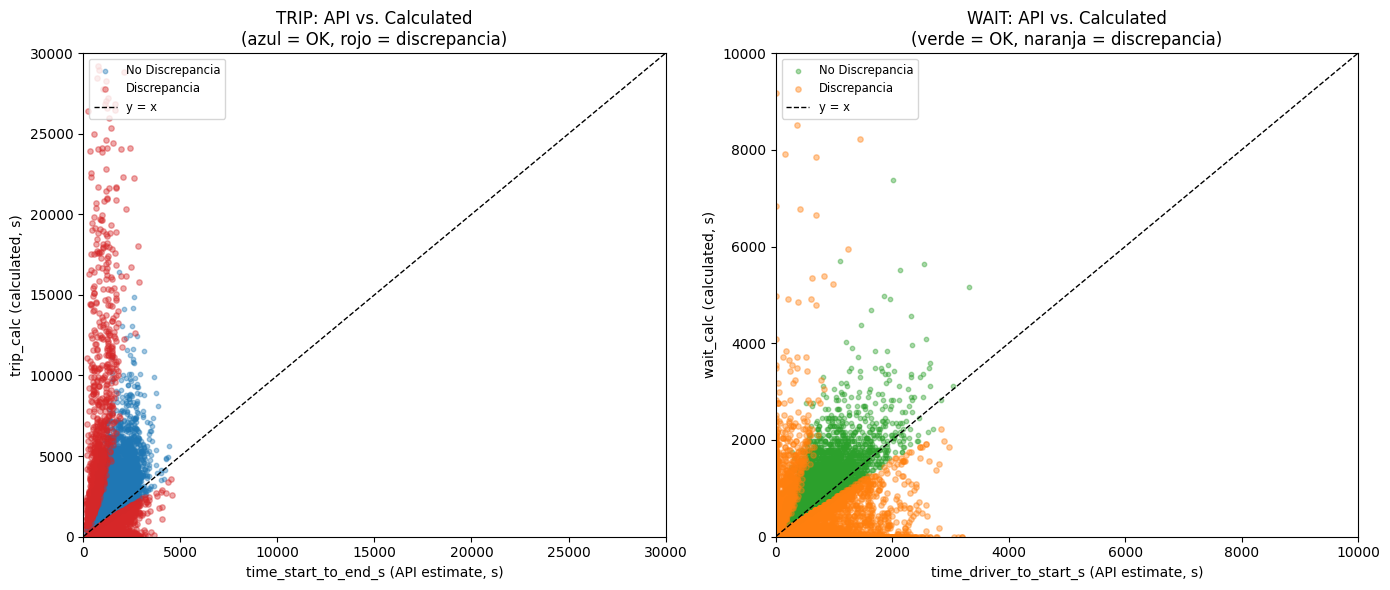

In [20]:
# ----------------------------------------------------------------------------
# 1) Define los límites deseados para cada gráfico (TRIP y WAIT)
# ----------------------------------------------------------------------------
# Para TRIP:
XMIN_TRIP, XMAX_TRIP = 0, 30000   # eje x: time_start_to_end_s en [0, 3000] segundos
YMIN_TRIP, YMAX_TRIP = 0, 30000  # eje y: trip_calc en [0, 10000] segundos

# Para WAIT:
XMIN_WAIT, XMAX_WAIT = 0, 10000   # eje x: time_driver_to_start_s en [0, 2000] segundos
YMIN_WAIT, YMAX_WAIT = 0, 10000   # eje y: wait_calc en [0, 5000] segundos

# ----------------------------------------------------------------------------
# 2) Prepara las máscaras booleanas (los mismos filtros que antes)
# ----------------------------------------------------------------------------
mask_trip_flagged    = df_drop['flag_discrepancia_trip'] == True
mask_trip_notflagged = df_drop['flag_discrepancia_trip'] == False

mask_wait_flagged    = df_drop['flag_discrepancia_wait'] == True
mask_wait_notflagged = df_drop['flag_discrepancia_wait'] == False

# ----------------------------------------------------------------------------
# 3) Crea los subplots lado a lado
# ----------------------------------------------------------------------------
fig, (ax_trip, ax_wait) = plt.subplots(1, 2, figsize=(14, 6))

# ----------------------------------------------------------------------------
# 4) GRÁFICO TRIP
# ----------------------------------------------------------------------------
# (a) puntos no discrepantes en azul pálido
ax_trip.scatter(
    df_drop.loc[mask_trip_notflagged, 'time_start_to_end_s'],
    df_drop.loc[mask_trip_notflagged, 'trip_calc'],
    c='tab:blue', s=10, alpha=0.4, label='No Discrepancia'
)

# (b) puntos discrepantes en rojo
ax_trip.scatter(
    df_drop.loc[mask_trip_flagged, 'time_start_to_end_s'],
    df_drop.loc[mask_trip_flagged, 'trip_calc'],
    c='tab:red', s=15, alpha=0.4, label='Discrepancia'
)

# (c) línea de referencia y = x, pero recortada al rango elegido:
lims_trip = [max(XMIN_TRIP, YMIN_TRIP), min(XMAX_TRIP, YMAX_TRIP)]
ax_trip.plot(lims_trip, lims_trip, 'k--', linewidth=1, label='y = x')

# (d) Ajuste de ejes a los límites fijos:
ax_trip.set_xlim(XMIN_TRIP, XMAX_TRIP)
ax_trip.set_ylim(YMIN_TRIP, YMAX_TRIP)

ax_trip.set_xlabel('time_start_to_end_s (API estimate, s)')
ax_trip.set_ylabel('trip_calc (calculated, s)')
ax_trip.set_title('TRIP: API vs. Calculated\n(azul = OK, rojo = discrepancia)')
ax_trip.legend(loc='upper left', fontsize='small')

# ----------------------------------------------------------------------------
# 5) GRÁFICO WAIT
# ----------------------------------------------------------------------------
# (a) puntos no discrepantes en verde pálido
ax_wait.scatter(
    df_drop.loc[mask_wait_notflagged, 'time_driver_to_start_s'],
    df_drop.loc[mask_wait_notflagged, 'wait_calc'],
    c='tab:green', s=10, alpha=0.4, label='No Discrepancia'
)

# (b) puntos discrepantes en naranja
ax_wait.scatter(
    df_drop.loc[mask_wait_flagged, 'time_driver_to_start_s'],
    df_drop.loc[mask_wait_flagged, 'wait_calc'],
    c='tab:orange', s=15, alpha=0.4, label='Discrepancia'
)

# (c) línea de referencia y = x, recortada al rango elegido:
lims_wait = [max(XMIN_WAIT, YMIN_WAIT), min(XMAX_WAIT, YMAX_WAIT)]
ax_wait.plot(lims_wait, lims_wait, 'k--', linewidth=1, label='y = x')

# (d) Ajuste de ejes a los límites fijos:
ax_wait.set_xlim(XMIN_WAIT, XMAX_WAIT)
ax_wait.set_ylim(YMIN_WAIT, YMAX_WAIT)

ax_wait.set_xlabel('time_driver_to_start_s (API estimate, s)')
ax_wait.set_ylabel('wait_calc (calculated, s)')
ax_wait.set_title('WAIT: API vs. Calculated\n(verde = OK, naranja = discrepancia)')
ax_wait.legend(loc='upper left', fontsize='small')

plt.tight_layout()
plt.show()


In [21]:
# 1) Anular arrived_at en las filas donde flag_discrepancia_wait == True
df_drop.loc[df_drop['flag_discrepancia_wait'], 'arrived_at'] = pd.NaT

# 2) Anular end_at en las filas donde flag_discrepancia_trip == True
df_drop.loc[df_drop['flag_discrepancia_trip'], 'end_at'] = pd.NaT

# 3) Verificar cuántas filas quedaron anuladas
n_arrived_nulos = df_drop['arrived_at'].isna().sum()
n_end_nulos     = df_drop['end_at'].isna().sum()
print(f"Arrived_at anuladas (total NaT en arrived_at): {n_arrived_nulos}")
print(f"End_at anuladas     (total NaT en end_at):     {n_end_nulos}")

# 3) Imputar 'arrived_at' directo desde la API:
mask_arrived_nulos = df_drop['arrived_at'].isna()
df_drop.loc[mask_arrived_nulos, 'arrived_at'] = (
    df_drop.loc[mask_arrived_nulos, 'start_at']
    + pd.to_timedelta(df_drop.loc[mask_arrived_nulos, 'time_driver_to_start_s'], unit='s')
)

#    Para filas en que imputamos arrived_at pero NO tenían discrepancia TRIP,
#    end_at quedó “antiguo” y causaría trip_calc erróneo.
mask_arrived_imputada = mask_arrived_nulos
mask_trip_no_disc    = ~df_drop['flag_discrepancia_trip']
mask_corregir_trip   = mask_arrived_imputada & mask_trip_no_disc

df_drop.loc[mask_corregir_trip, 'end_at'] = pd.NaT

# 6) Recalcular 'trip_start' basado en el arrived_at corregido
df_drop['trip_start'] = df_drop[['start_at', 'arrived_at']].max(axis=1)

df_drop.loc[mask_corregir_trip, 'end_at'] = (
    df_drop.loc[mask_corregir_trip, 'trip_start']
    + pd.to_timedelta(df_drop.loc[mask_corregir_trip, 'trip_calc'], unit='s')
)

# 5) Imputar 'end_at' directo desde la API:
mask_end_nulos = df_drop['end_at'].isna()
df_drop.loc[mask_end_nulos, 'end_at'] = (
    df_drop.loc[mask_end_nulos, 'trip_start']
    + pd.to_timedelta(df_drop.loc[mask_end_nulos, 'time_start_to_end_s'], unit='s')
)

# 6) Recalcular 'wait_calc' y 'trip_calc' a partir de los timestamps completos
df_drop['wait_calc'] = (
    (df_drop['arrived_at'] - df_drop['start_at'])
    .dt.total_seconds()
    .clip(lower=0)
)

df_drop['trip_start'] = df_drop[['start_at', 'arrived_at']].max(axis=1)
df_drop['trip_calc'] = (
    (df_drop['end_at'] - df_drop['trip_start'])
    .dt.total_seconds()
    .clip(lower=0)
)

# 7) Verificación final de que ya no haya NaN/NaT en wait_calc/trip_calc
print("Nulos después de imputación:")
print("   arrived_at NaT:", df_drop['arrived_at'].isna().sum())
print("   end_at     NaT:", df_drop['end_at'].isna().sum())
print("   wait_calc  NaN:", df_drop['wait_calc'].isna().sum())
print("   trip_calc  NaN:", df_drop['trip_calc'].isna().sum())


Arrived_at anuladas (total NaT en arrived_at): 9138
End_at anuladas     (total NaT en end_at):     3595
Nulos después de imputación:
   arrived_at NaT: 156
   end_at     NaT: 0
   wait_calc  NaN: 156
   trip_calc  NaN: 0


In [22]:
mask_arrived_faltante = df_drop['arrived_at'].isna()
n_faltantes = mask_arrived_faltante.sum()
print(f"Filas con arrived_at NaT tras imputación previa: {n_faltantes}")

# ------------------------------------------------------------
# (4) Calcular la mediana global de wait_calc entre las filas válidas
# ------------------------------------------------------------
mediana_global = df_drop.loc[df_drop['arrived_at'].notna(), 'wait_calc'].median()
print(f"Mediana global de wait_calc (filas con arrived_at válido): {mediana_global:.2f} s")

# ------------------------------------------------------------
# (5) Imputar wait_calc = mediana_global en las filas faltantes
# ------------------------------------------------------------
df_drop.loc[mask_arrived_faltante, 'wait_calc'] = mediana_global

# ------------------------------------------------------------
# (6) Reconstruir arrived_at para esas filas
# ------------------------------------------------------------
df_drop.loc[mask_arrived_faltante, 'arrived_at'] = (
    df_drop.loc[mask_arrived_faltante, 'start_at']
    + pd.to_timedelta(df_drop.loc[mask_arrived_faltante, 'wait_calc'], unit='s')
)

# ------------------------------------------------------------
# (7) Recalcular wait_calc y trip_calc en todo el DataFrame
# ------------------------------------------------------------
df_drop['wait_calc'] = (
    (df_drop['arrived_at'] - df_drop['start_at'])
    .dt.total_seconds()
    .clip(lower=0)
)

df_drop['trip_start'] = df_drop[['start_at', 'arrived_at']].max(axis=1)
df_drop['trip_calc'] = (
    (df_drop['end_at'] - df_drop['trip_start'])
    .dt.total_seconds()
    .clip(lower=0)
)

# ------------------------------------------------------------
# (8) Verificación final: no debería quedar ningún NaN/NaT en arrived_at, wait_calc ni trip_calc
# ------------------------------------------------------------
print("\n>> Nulos después de la imputación con mediana global:")
print("   arrived_at NaT:", df_drop['arrived_at'].isna().sum())
print("   wait_calc  NaN:", df_drop['wait_calc'].isna().sum())
print("   trip_calc  NaN:", df_drop['trip_calc'].isna().sum())

Filas con arrived_at NaT tras imputación previa: 156
Mediana global de wait_calc (filas con arrived_at válido): 540.00 s

>> Nulos después de la imputación con mediana global:
   arrived_at NaT: 0
   wait_calc  NaN: 0
   trip_calc  NaN: 0


In [23]:
aux_columns = [
    'trip_start',
    'speed_real_trip_kmh',
    'speed_api_trip_kmh',
    'flag_inconsistencia_grave_trip',
    'speed_real_wait_kmh',
    'speed_api_wait_kmh',
    'flag_inconsistencia_grave_wait',
    'api_time_corr_trip',
    'api_time_corr_wait',
    'error_abs_trip',
    'error_rel_corr_trip',
    'error_abs_wait',
    'error_rel_corr_wait',
    'flag_discrepancia_trip',
    'flag_discrepancia_wait'
]

df_drop.drop(columns=aux_columns, inplace=True)

In [24]:
def outliers(
    df : pd.DataFrame,
    col : str,
    rango : range = range(0,101),
    intervalo : int = 1000
) :
    '''
    Genera un gráfico interactivo de línea que muestra el valor de cada percentil
    de la columna especificada.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame de entrada; se eliminan filas con valores NaN en `start_lat`.
    col : str
        Nombre de la columna de la que calcular los percentiles.
    rango : range, opcional
        Rango de percentiles a evaluar (por defecto 0-100).
    intervalo : int, opcional
        Número de divisiones usadas para calcular los quantiles (por defecto 1000).

    Devuelve
    -------
    alt.Chart
        Gráfico Altair interactivo con percentil (eje x) vs. valor (eje y).
    '''
    df = df.dropna(subset=col)
    resultados = []
    
    for i in rango:
        valor = df[col].quantile(i / intervalo)
        resultados.append(
            {
                'p' : i/(intervalo/100),
                'valor' : valor
            }
        )

    df_res = pd.DataFrame(resultados)

    chart = (
        alt.Chart(df_res, width=700, height=400)
        .mark_line(point=True)
        .encode(
            x=alt.X('p:Q', title='Percentil (p)'),
            y=alt.Y('valor:Q', title=col),
            tooltip=[
                alt.Tooltip('p:Q', format='.1f', title='p'),
                alt.Tooltip('valor:Q', format='.2f', title=col)
            ]
        )
        .interactive()
    )

    return chart

In [25]:
outliers(
    df_drop,
    col='price',
    rango=range(0,101),
    intervalo=100
)

alt.Chart(...)

In [26]:
df_drop.loc[(df_drop.price < 1700) | (df_drop.price > 14953.52), 'price'] = np.nan

In [27]:
df_drop['hour'] = df_drop['start_at'].dt.hour
df_drop['weekday'] = df_drop['start_at'].dt.weekday      # 0=Lunes … 6=Domingo
df_drop['weekday_name'] = df_drop['start_at'].dt.day_name()

In [28]:
# 1) Candidate variables
candidates = [
    'dist_start_to_end_m',
    'dist_driver_to_start_m',
    'trip_calc',
    'wait_calc',
    'hour'
]

# 2) Prepare DataFrame for modeling
df_mod = df_drop.dropna(subset=['price'] + candidates).copy()
y = df_mod['price']
X = df_mod[candidates]

# 3) Iterative VIF filtering (drop VIF > 10)
X_const = sm.add_constant(X)
while True:
    vif = pd.Series(
        [variance_inflation_factor(X_const.values, i)
         for i in range(X_const.shape[1])],
        index=X_const.columns
    ).drop('const')
    max_vif = vif.max()
    if max_vif <= 10:
        break
    drop_var = vif.idxmax()
    print(f"Dropping '{drop_var}' due to high VIF ({max_vif:.1f})")
    X = X.drop(columns=[drop_var])
    X_const = sm.add_constant(X)

print("Variables after VIF filtering:", list(X.columns))

# 4) Initial robust fit (HC3)
model = sm.OLS(y, X_const).fit(cov_type='HC3')
print(model.summary())

# 5) Drop non-significant predictors (p > 0.05)
pvals = pd.Series(model.pvalues, index=X_const.columns)
insig = pvals[pvals > 0.05].drop('const', errors='ignore').index.tolist()
if insig:
    print("Dropping non-significant predictors:", insig)
    X = X.drop(columns=insig)
    X_const = sm.add_constant(X)
else:
    print("All predictors significant at 5%")

# 6) Final robust fit
final = sm.OLS(y, X_const).fit(cov_type='HC3')
print(final.summary())

# 7) Influence diagnostics
infl = OLSInfluence(final)
df_mod['std_resid'] = infl.resid_studentized_internal
df_mod['cooks_d']   = infl.cooks_distance[0]
df_mod['leverage']  = infl.hat_matrix_diag

# 8) outlier flags
n = len(df_mod)
df_mod['outlier'] = (
    df_mod['std_resid'].abs() > 2
) | (
    df_mod['cooks_d'] > (3/n)
) | (
    df_mod['leverage'] > 1*(len(X_const))/n
)
print(f"outliers: {df_mod['outlier'].sum()} of {n}")

Variables after VIF filtering: ['dist_start_to_end_m', 'dist_driver_to_start_m', 'trip_calc', 'wait_calc', 'hour']
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     2428.
Date:                Mon, 02 Jun 2025   Prob (F-statistic):               0.00
Time:                        23:17:07   Log-Likelihood:            -1.3794e+05
No. Observations:               15849   AIC:                         2.759e+05
Df Residuals:                   15843   BIC:                         2.759e+05
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
----

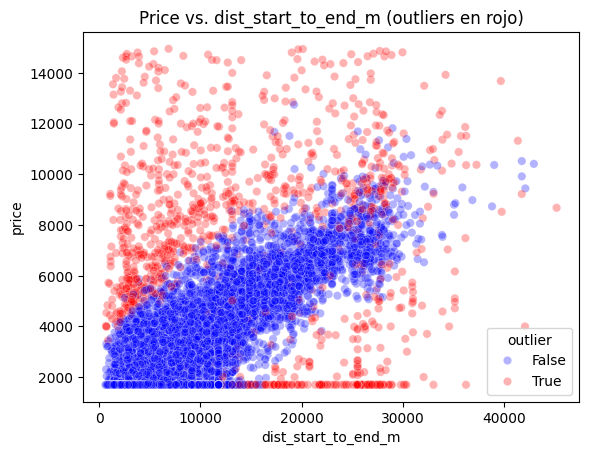

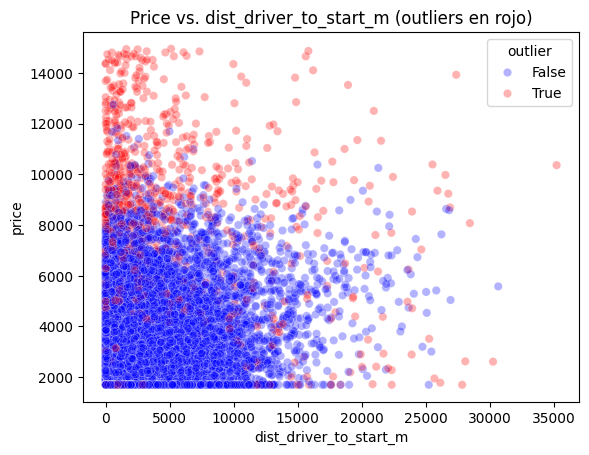

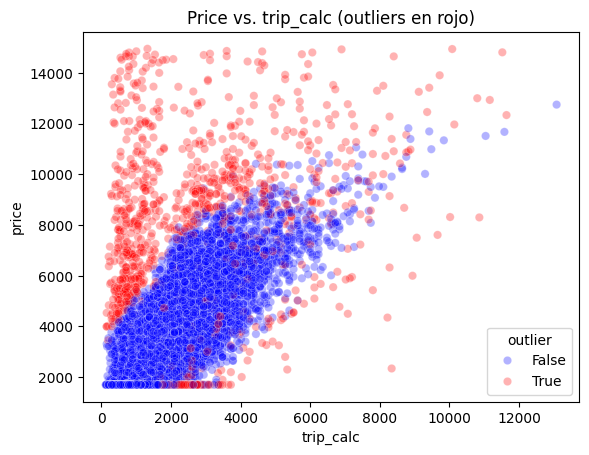

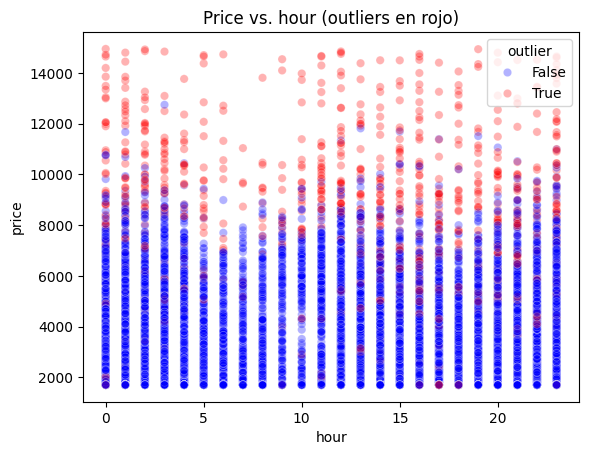

In [29]:
for var in X.columns :
    sns.scatterplot(
        data=df_mod, x=var, y='price',
        hue='outlier', palette={False:'blue',True:'red'}, alpha=0.3
    )
    plt.title(f'Price vs. {var} (outliers en rojo)')
    plt.show()


In [30]:
df_drop = df_drop.merge(
    df_mod[['outlier']],
    how='left',
    left_index=True,
    right_index=True
)

df_drop.loc[df_drop['outlier'] == True, 'price'] = np.nan
df_drop.drop(
    columns=['outlier'],
    inplace=True
)

In [31]:
# Variables significativas para imputar precio
sig_vars = X.columns

# Preparamos DataFrame con esas variables + price
cols = sig_vars.to_list() + ['price']

# Save the index before reset
df_price = df_drop[cols].copy()
df_price['orig_index'] = df_price.index

# Reset index just for miceforest (required for some operations)
df_price_reset = df_price.reset_index(drop=True)

# Run MICE on reset df
kernel = mf.ImputationKernel(data=df_price_reset, random_state=0)
kernel.mice(iterations=50)

# Recover imputed data and restore original index
imputed_df = kernel.complete_data(dataset=0)
imputed_df['orig_index'] = df_price['orig_index'].values
imputed_df = imputed_df.set_index('orig_index').sort_index()

print(f"Se imputaron {df_drop.price.isna().sum()} valores de 'price' usando miceforest")

# Now safely update only the missing prices
df_drop.loc[df_drop['price'].isna(), 'price'] = imputed_df.loc[df_drop['price'].isna(), 'price']

Se imputaron 1458 valores de 'price' usando miceforest


In [32]:
null_percent = df_drop.isnull().mean().sort_values(ascending=False)
print(null_percent[null_percent > 0].apply(lambda x : f'{x:.2%}'))  # Solo columnas con nulos

tp                        96.06%
driver_score              55.71%
d2m                       41.45%
time_grid                 41.45%
lon_grid                  41.45%
lat_grid                  41.45%
v10                       41.45%
u10                       41.45%
t2m                       41.45%
tcc                       41.45%
rider_score               11.57%
driver_start_lon           4.17%
time_driver_to_start_s     4.17%
driver_start_lat           4.17%
dist_driver_to_start_m     4.17%
source                     0.57%
dest_density               0.14%
dest_pop                   0.14%
origin_pop                 0.08%
origin_density             0.08%
dtype: object


## Exportar

In [36]:
df_drop.to_csv(
    'completed_uber_rides_clean.csv',
    index=False
)